# 4.3 Bayesian Regression

## Objectives

+ Intro: Definitions and motivation
+ Bayesian regression: linear,nonlinear,polynomial multiple.
+ Implementing Height and Weight example in PyMC3 and in Bambi.

               

## Definitions


### Bayesian linear regression:
Bayesian linear regression is an approach to linear regression in which the statistical analysis is undertaken within the context of Bayesian inference. When the regression model has errors that have a normal distribution, and if a particular form of prior distribution is assumed, explicit results are available for the posterior probability distributions of the model's parameters.
                                  
                                    



## Introduction

## Tensorflow Probability:

TensorFlow Probability (TFP) is a Python library built on TensorFlow that makes it easy to combine probabilistic models and deep learning on modern hardware (TPU, GPU). It's for data scientists, statisticians, ML researchers, and practitioners who want to encode domain knowledge to understand data and make predictions. TFP includes:

- A wide selection of probability distributions and bijectors.
- Tools to build deep probabilistic models, including probabilistic layers and the Edward2 language.
- Variational inference and Markov chain Monte Carlo.
- Optimizers such as Nelder-Mead, BFGS, and SGLD.

Since TFP inherits the benefits of TensorFlow, you can build, fit, and deploy a model using a single language throughout the lifecycle of model exploration and production. 


### Coding 

In [0]:
%matplotlib inline
import io
from google.colab import files
import numpy as np;
import pandas as pd
from scipy import stats
import pymc3 as pm
from scipy.stats import norm
from scipy.interpolate import griddata
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import seaborn as sns;
import time

tfd = tfp.distributions
%config InlineBackend.figure_format = 'retina'
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])

code 4.1


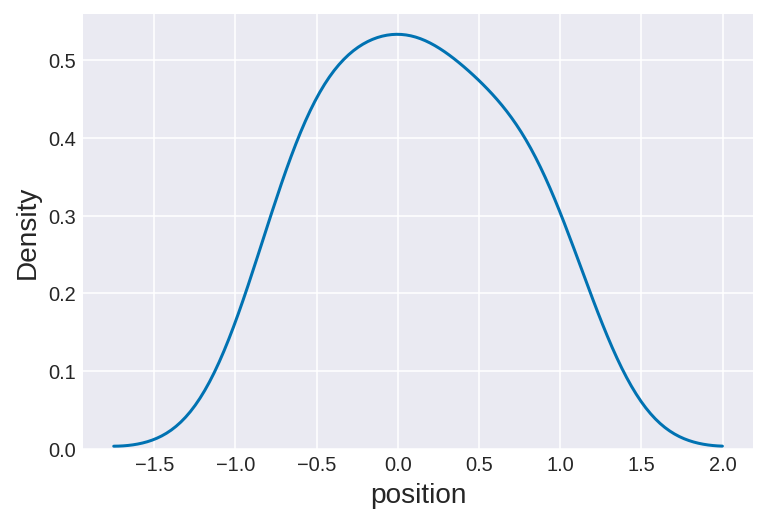

In [2]:
# Build the model
pos = tfd.Uniform(low=-1., high=1.).sample(16,1000)
with tf.Session() as sess:
  pos = sess.run(pos)

# Plot the model
sns.kdeplot(pos)
plt.xlabel('position', fontsize=14)
plt.ylabel('Density', fontsize=14);

Code 4.2 and 4.3

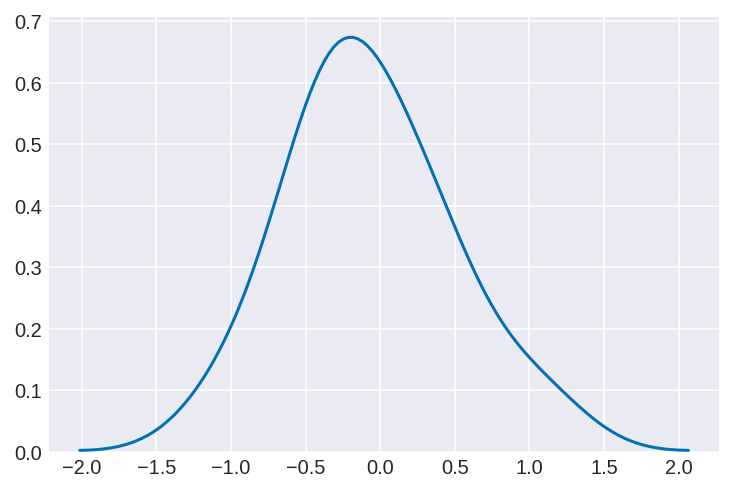

In [3]:
# Build the model
pos = tfd.Uniform(low=-1., high=1.1).sample(12,10000)
with tf.Session() as sess:
  pos = sess.run(pos)

# Plot the model
sns.kdeplot(pos);

code 4.4

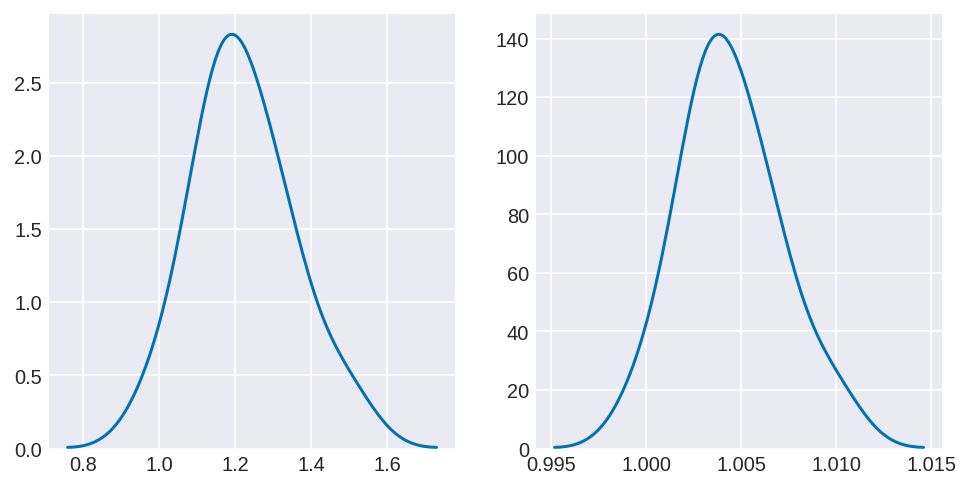

In [4]:
# Build the model
big = tfd.Uniform(low=1., high=1.5).sample(12,10000)
with tf.Session() as sess:
  big = sess.run(big)

small = tfd.Uniform(low=1., high=1.01).sample(12,10000)
with tf.Session() as sess:
  small = sess.run(small)

# Plot the model
_, ax = plt.subplots(1,2, figsize=(8,4))
sns.kdeplot(big, ax=ax[0])
sns.kdeplot(small, ax=ax[1]);

code 4.5

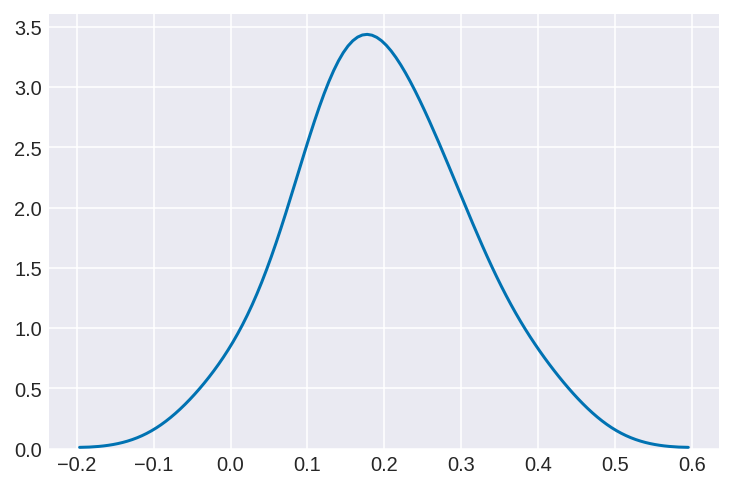

In [5]:
# Build the model
big = tfd.Uniform(low=1., high=1.5).sample(12,10000)
with tf.Session() as sess:
  log_big = np.log(sess.run(big))

# Plot the model
sns.kdeplot(log_big);

code 4.6

W0725 22:39:50.864733 140329500174208 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_probability/python/distributions/uniform.py:182: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


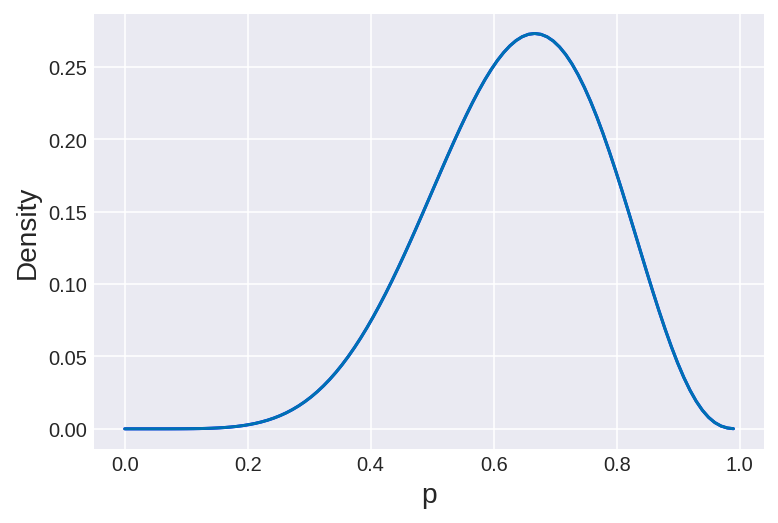

In [6]:
# Build the model
w = 6.0
n = 9.0
p_grid = np.linspace(0, 1, 100)

binom = tfd.Binomial(total_count=n, probs=p_grid).prob(6)
binom = tf.dtypes.cast(binom, tf.float32)
uniform = tfd.Uniform(low=0., high=1.).prob(p_grid)
uniform = tf.dtypes.cast(uniform, tf.float32)

posterior = tf.multiply(binom, uniform)
with tf.Session() as sess:
  posterior = sess.run(posterior)
  posterior / np.sum(posterior)

# Plot the model
plt.plot(p_grid, posterior, 'b')
plt.xlabel('p', fontsize=14)
plt.ylabel('Density', fontsize=14);

plt.plot(p_grid, posterior)
plt.xlabel('p', fontsize=14)
plt.ylabel('Density', fontsize=14);


Code 4.7 and 4.8



In [80]:
# Read the data

uploaded = files.upload()
d = pd.read_csv(io.BytesIO(uploaded['Howell1.csv']), sep=';', header=0)
d.head()

Saving Howell1.csv to Howell1 (2).csv


,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0


Code 4.9

In [81]:
# Select height column
d.height.head()

0    151.765
1    139.700
2    136.525
3    156.845
4    145.415
Name: height, dtype: float64

code  4.10 and 4.11

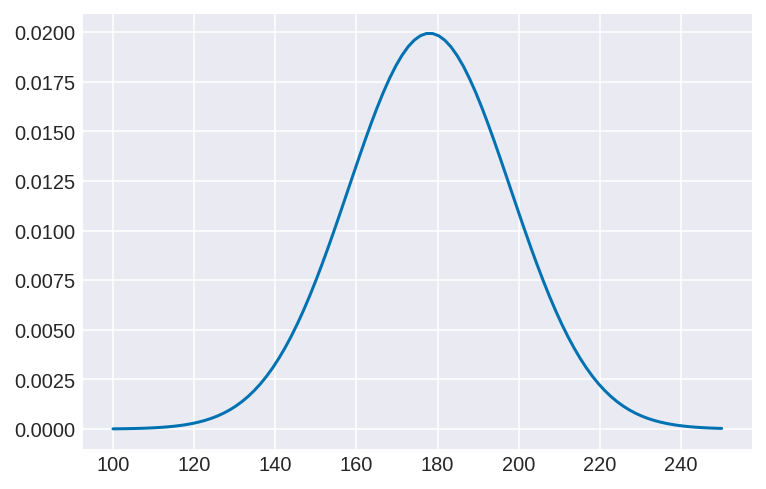

In [82]:
# Height column where age > 18
d2 = d[d.age >= 18]
x = np.linspace(100, 250, 100)

height = tfd.Normal(loc=178., scale=20.).prob(x)
with tf.Session() as sess:
  height = sess.run(height)

plt.plot(x, height);

code 4.12

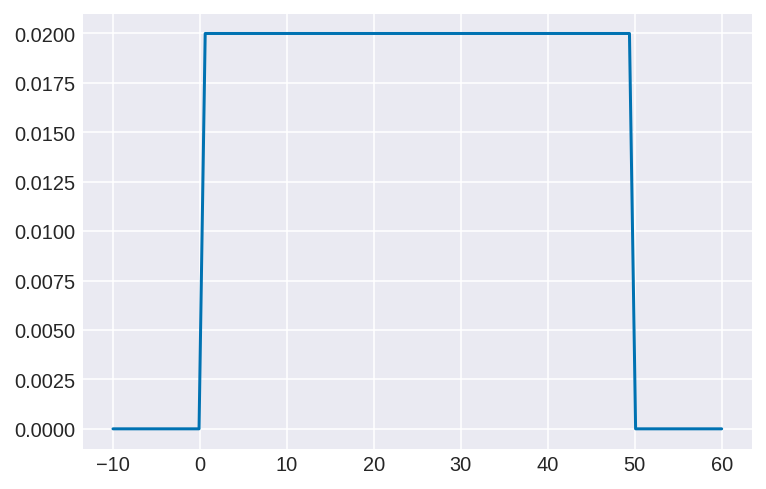

In [10]:
# Plot uniform distribution
x = np.linspace(-10, 60, 100)

uniform = tfd.Uniform(low=0., high=50.).prob(x)
with tf.Session() as sess:
  uniform = sess.run(uniform)

plt.plot(x, uniform);

code 4.13

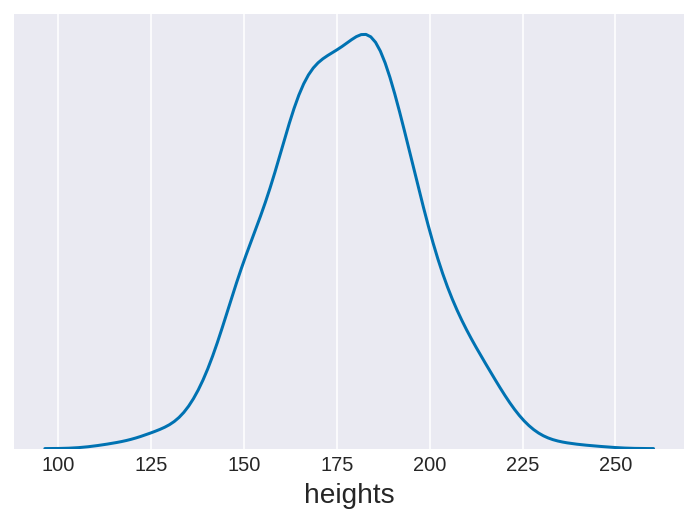

In [11]:
# Prior
sample_mu = tfd.Normal(loc=178., scale=20.).sample(1000)
sample_sigma = tfd.Uniform(low=0., high=50.).sample(1000)
prior_h = tfd.Normal(loc=sample_mu, scale=sample_sigma).sample(1000)
with tf.Session() as sess:
  prior_h = sess.run(prior_h)
  prior_h = sum(prior_h)/1000

# Plot the prior
sns.kdeplot(prior_h)
plt.xlabel('heights', fontsize=14)
plt.yticks([]);

code 4.14

In [0]:
post = np.mgrid[140.:160.:0.1, 4.:9.:0.1].reshape(2,-1).T

# Likelihood
value = len(post)
scope = len(d2.height)

likelihood = np.zeros(scope)

for i in range(value):
  dist = tfd.Normal(loc=post[:,0][i], scale=post[:,1][i]).log_prob(d2.height)
  with tf.Session() as sess:
    dist = sess.run(dist)
    likelihood = likelihood + dist

# Baysian Inference
mu = tfd.Normal(loc=178., scale=20.).log_prob(post[:,0])
with tf.Session() as sess:
  mu = sess.run(mu)

sigma = tfd.Uniform(low=0., high = 50.).log_prob(post[:,1])
with tf.Session() as sess:
  sigma = sess.run(sigma)
  
post_prod = likelihood + mu + sigma
post_prob = np.exp(post_prod - max(post_prod))

print(post_prob)

In [0]:
post = np.mgrid[140:160:0.1, 4:9:0.1].reshape(2,-1).T

likelihood = [sum(stats.norm.logpdf(d2.height, loc=post[:,0][i], scale=post[:,1][i])) for i in range(len(post))]

post_prod = (likelihood + 
             stats.norm.logpdf(post[:,0], loc=178, scale=20) + 
             stats.uniform.logpdf(post[:,1], loc=0, scale=50))
post_prob = np.exp(post_prod - max(post_prod))

Code 4.15 and 4.16

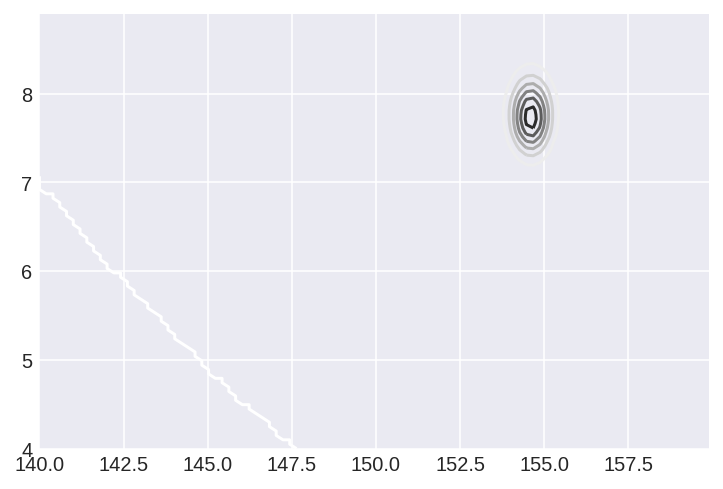

In [13]:
# Plot the posterior
xi = np.linspace(post[:,0].min(), post[:,0].max(), 100)
yi = np.linspace(post[:,1].min(), post[:,1].max(), 100)
zi = griddata((post[:,0], post[:,1]), post_prob, (xi[None,:], yi[:,None]))

plt.contour(xi, yi, zi);

Code 4.17 and 4.18

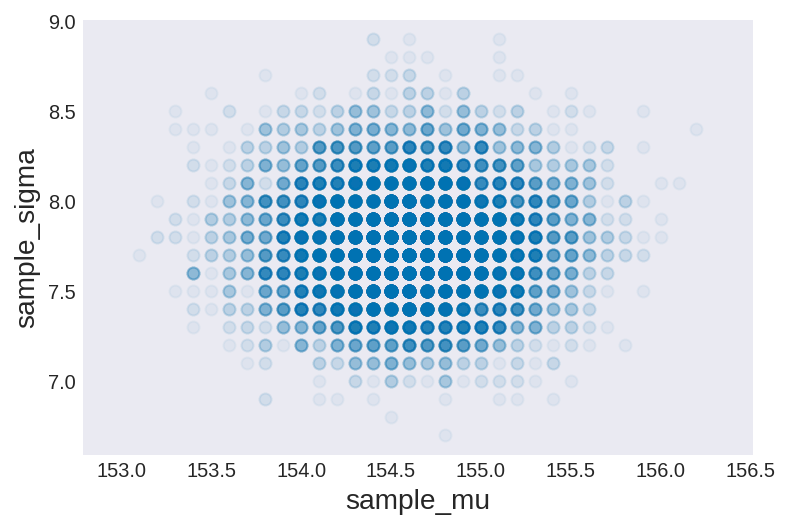

In [14]:
# Sampling
sample_rows = np.random.choice(np.arange(len(post)), size=10000, replace=True, 
                               p=(post_prob/post_prob.sum()))
sample_mu = post[:,0][sample_rows]
sample_sigma = post[:,1][sample_rows]

plt.plot(sample_mu, sample_sigma, 'o', alpha=0.05)
plt.axis('equal')
plt.grid(False)
plt.xlabel('sample_mu', fontsize=14)
plt.ylabel('sample_sigma', fontsize=14);

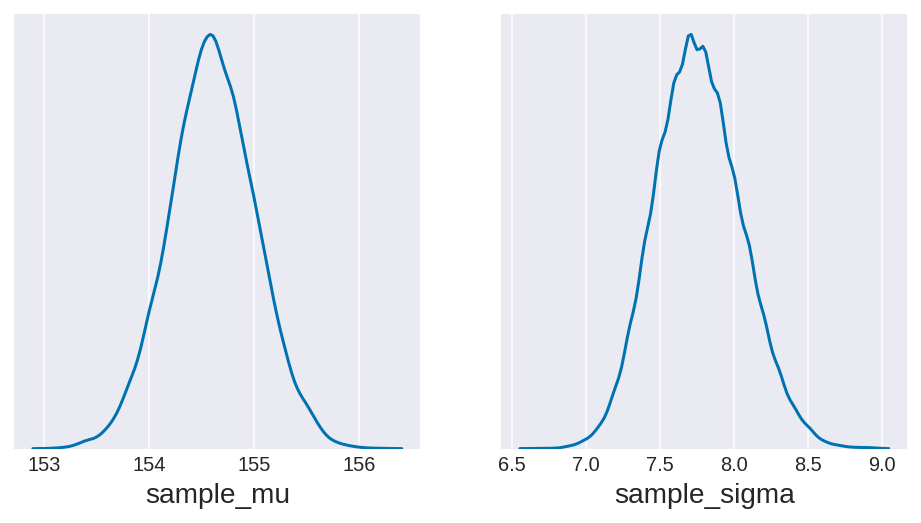

In [15]:
# Plot sampled data
_, ax = plt.subplots(1,2, figsize=(8,4))
sns.kdeplot(sample_mu, ax=ax[0])
ax[0].set_xlabel('sample_mu', fontsize=14)
ax[0].set_yticks([])
sns.kdeplot(sample_sigma, ax=ax[1])
ax[1].set_xlabel('sample_sigma', fontsize=14)
ax[1].set_yticks([]);

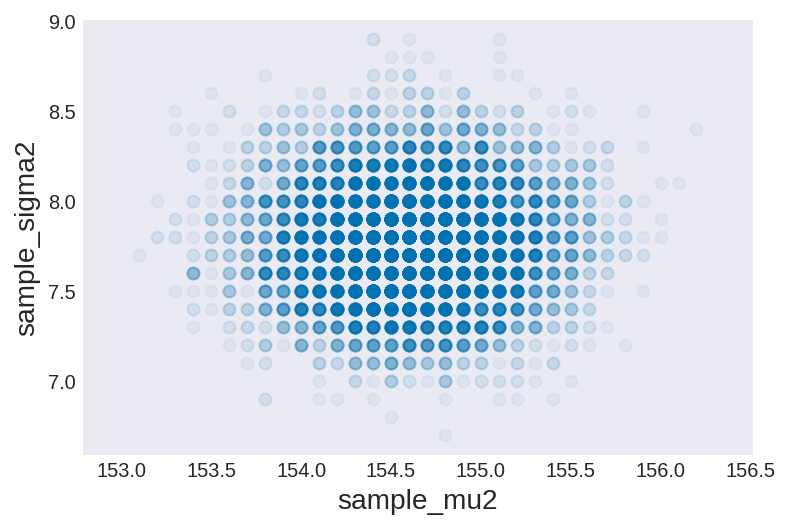

In [16]:
d3 = np.random.choice(d2.height, 20)
post2 = np.mgrid[150:170:0.1, 4:20:0.1].reshape(2,-1).T

likelihood2 = [sum(stats.norm.logpdf(d3, loc=post[:,0][i], scale=post[:,1][i])) for i in range(len(post))]

post_prod2 = (likelihood + 
              stats.norm.logpdf(post[:,0], loc=178, scale=20) + 
              stats.uniform.logpdf(post[:,1], loc=0, scale=50))

post_prob2 = np.exp(post_prod - max(post_prod))

sample_rows2 = np.random.choice(np.arange(len(post)), size=10000, replace=True, 
                               p=(post_prob/post_prob.sum()))
sample_mu2 = post[:,0][sample_rows]
sample_sigma2 = post[:,1][sample_rows]

plt.plot(sample_mu2, sample_sigma2, 'o', alpha=0.05)
plt.axis('equal')
plt.xlabel('sample_mu2', fontsize=14)
plt.ylabel('sample_sigma2', fontsize=14)
plt.grid(False)

In [0]:
d3 = np.random.choice(d2.height, 20)
post2 = np.mgrid[150:170:0.1, 4:20:0.1].reshape(2,-1).T

# Likelihood
value2 = len(post)
scope2 = len(d3)

likelihood2 = np.zeros(scope2)

for i in range(value2):
  dist = tfd.Normal(loc=post[:,0][i], scale=post[:,1][i]).log_prob(d3)
  with tf.Session() as sess:
    dist = sess.run(dist)
    likelihood = likelihood + dist

# Baysian Inference
mu = tfd.Normal(loc=178., scale=20.).log_prob(post[:,0])
with tf.Session() as sess:
  mu = sess.run(mu)

sigma = tfd.Uniform(low=0., high = 50.).log_prob(post[:,1])
with tf.Session() as sess:
  sigma = sess.run(sigma)
  
post_prod2 = likelihood + mu + sigma
post_prob2 = np.exp(post_prod2 - max(post_prod2))

print(post_prob2)

sample_rows2 = np.random.choice(np.arange(len(post)), size=10000, replace=True, 
                               p=(post_prob2/post_prob2.sum()))
sample_mu2 = post2[:,0][sample_rows]
sample_sigma2 = post2[:,1][sample_rows]

plt.plot(sample_mu2, sample_sigma2, 'o', alpha=0.05)
plt.axis('equal')
plt.xlabel('sample_mu2', fontsize=14)
plt.ylabel('sample_sigma2', fontsize=14)
plt.grid(False)

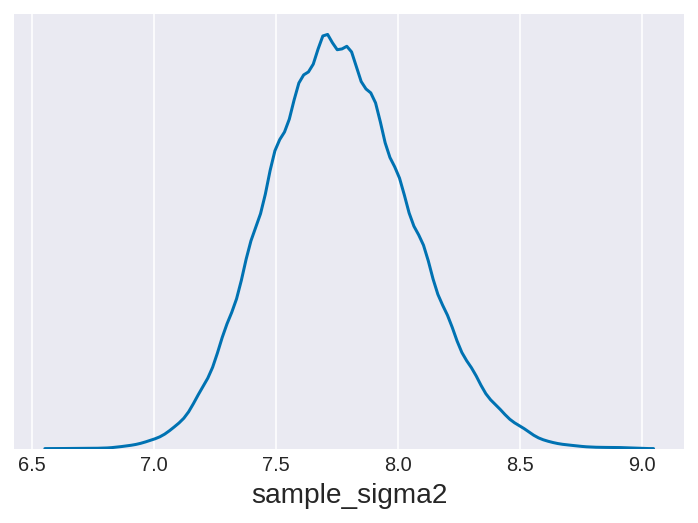

In [17]:
sns.kdeplot(sample_sigma2)
plt.xlabel('sample_sigma2', fontsize=14)
plt.yticks([]);

### Build the model m4_1

In [0]:
# Observed data
n = len(d2)
true_mu = 178.
true_sigma = 20.

xs = np.random.uniform(1, 50, n)
ys = d2.height

# Prior
rv_mu= tfd.Normal(loc=178., scale=20.).log_prob(true_mu)
rv_sigma = tfd.Uniform(low=0., high=50.).log_prob(true_sigma)

# Calculate the likelihood
rv_likelihood = tfd.Normal(loc=true_mu, scale=true_sigma).log_prob

### Sampling the model

In [0]:
# Sampling likelihood
states = tfp.mcmc.sample_chain(
    num_results=50000,
    num_burnin_steps=500,
    current_state = tf.zeros(1),
    kernel=tfp.mcmc.HamiltonianMonteCarlo(
      target_log_prob_fn=rv_likelihood,
      step_size=0.5,
      num_leapfrog_steps=2),
    trace_fn=None)

### Trace the result

In [43]:
# Calculate sampled mu
sampled_mu = states

# Calculate sampled sigma
sampled_sigma = tf.sqrt(tf.math.squared_difference(sampled_mu, true_mu))

with tf.Session() as sess:
  sampled_mu = sess.run(sampled_mu)
mean_mu = np.mean(sampled_mu)
print("The estimated mu is:", mean_mu)

with tf.Session() as sess:
  sampled_sigma = sess.run(sampled_sigma)
mean_sigma = np.mean(sampled_sigma)
print("The estimated sigma is:", mean_sigma)

The estimated mu is: 177.8129
The estimated sigma is: 15.769818


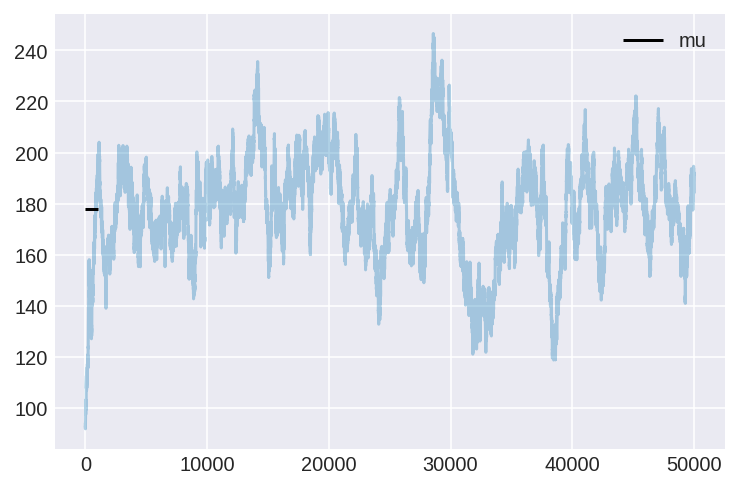

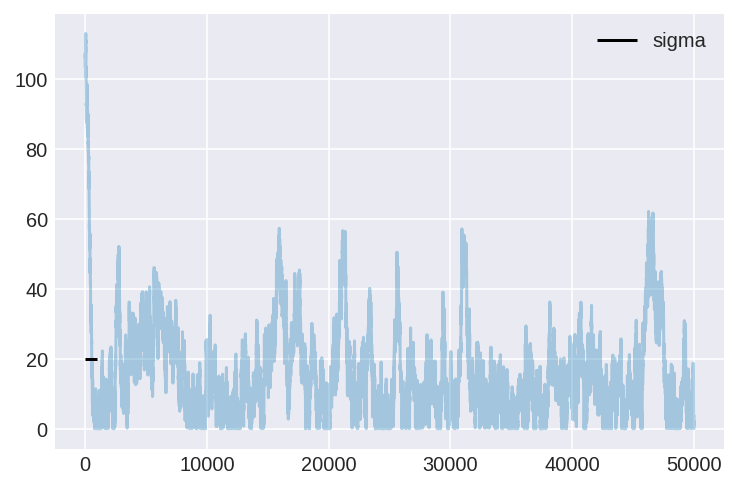

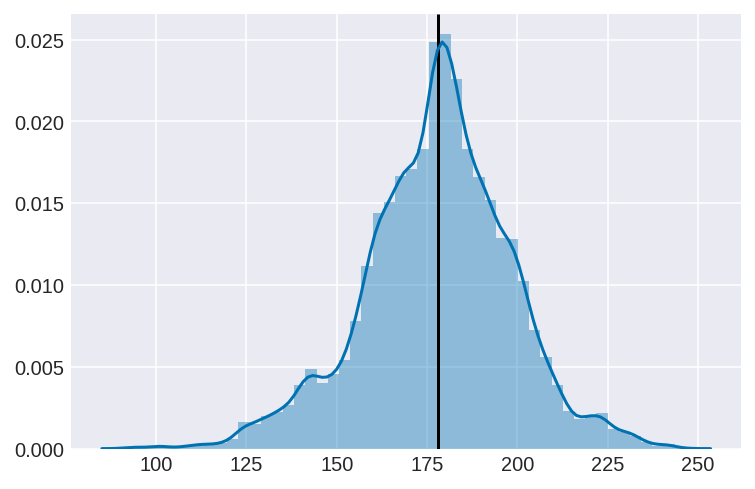

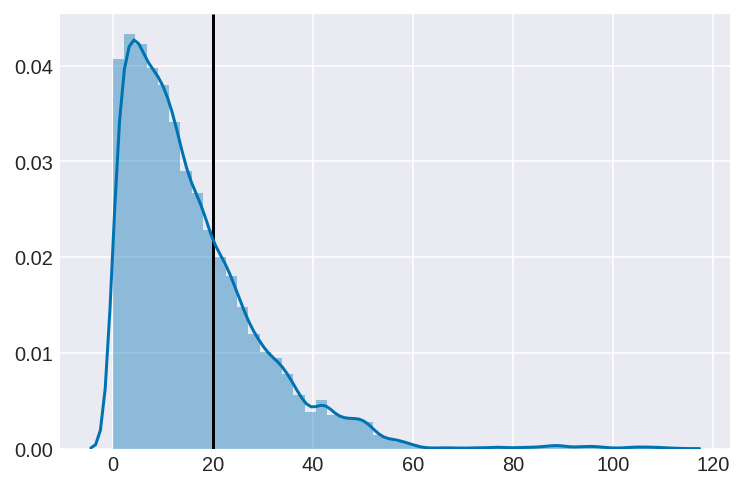

In [44]:
# Trace plots
plt.plot(sampled_mu, alpha=.3)
plt.hlines(true_mu, 0, 1000, zorder=4, label="mu")
plt.legend(loc='upper right')
plt.show()

plt.plot(sampled_sigma, alpha=.3)
plt.hlines(true_sigma, 0, 1000, zorder=4, label="sigma")
plt.legend(loc='upper right')
plt.show()

# Histogram of samples
sns.distplot(sampled_mu)
ymax = plt.ylim()[1]
plt.vlines(true_mu, 0, ymax)
plt.ylim(0, ymax)
plt.show()

sns.distplot(sampled_sigma)
ymax = plt.ylim()[1]
plt.vlines(true_sigma, 0, ymax)
plt.ylim(0, ymax)
plt.show()

### Build the model m4_2

In [0]:
# Observed data
n = len(d2)
true_mu = 178.
true_sigma = 20.

xs = np.random.uniform(1, 50, n)
ys = d2.height

# Prior
rv_mu= tfd.Normal(loc=178., scale=0.1).log_prob(true_mu)
rv_sigma = tfd.Uniform(low=0., high=50.).log_prob(true_sigma)

# Calculate the likelihood
rv_likelihood = tfd.Normal(loc=true_mu, scale=true_sigma).log_prob

### Sampling the model

In [0]:
# Sampling likelihood
states = tfp.mcmc.sample_chain(
    num_results=50000,
    num_burnin_steps=500,
    current_state = tf.zeros(1),
    kernel=tfp.mcmc.HamiltonianMonteCarlo(
      target_log_prob_fn=rv_likelihood,
      step_size=0.5,
      num_leapfrog_steps=2),
    trace_fn=None)

### Trace the result

In [57]:
# Calculate sampled mu
sampled_mu = states

# Calculate sampled sigma
sampled_sigma = tf.sqrt(tf.math.squared_difference(sampled_mu, true_mu))

with tf.Session() as sess:
  sampled_mu = sess.run(sampled_mu)
mean_mu = np.mean(sampled_mu)
print("The estimated mu is:", mean_mu)

with tf.Session() as sess:
  sampled_sigma = sess.run(sampled_sigma)
mean_sigma = np.mean(sampled_sigma)
print("The estimated sigma is:", mean_sigma)

The estimated mu is: 180.1328
The estimated sigma is: 15.925157


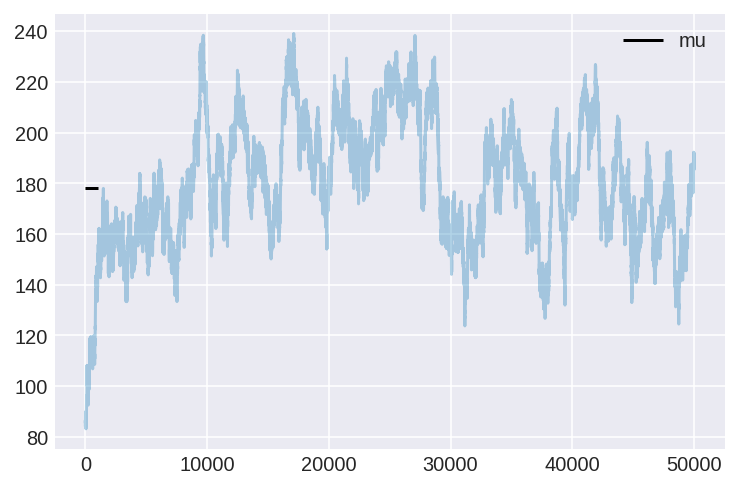

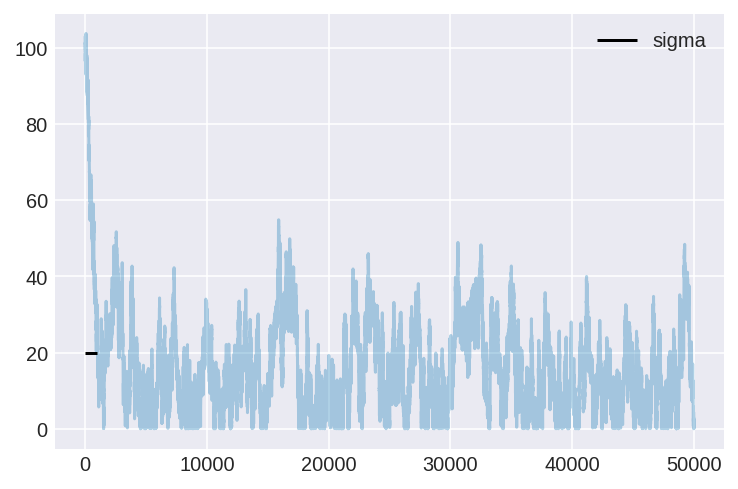

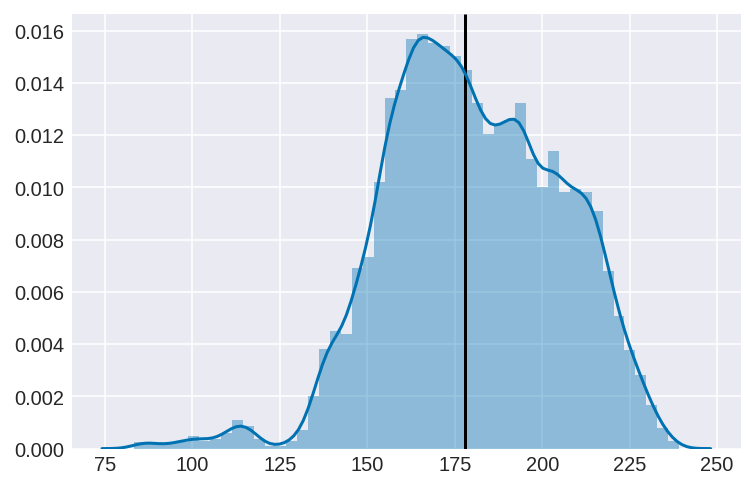

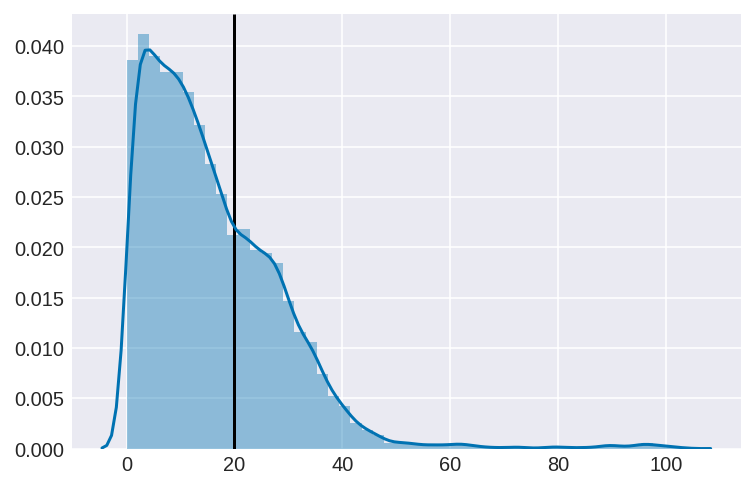

In [58]:
# Trace plots
plt.plot(sampled_mu, alpha=.3)
plt.hlines(true_mu, 0, 1000, zorder=4, label="mu")
plt.legend(loc='upper right')
plt.show()

plt.plot(sampled_sigma, alpha=.3)
plt.hlines(true_sigma, 0, 1000, zorder=4, label="sigma")
plt.legend(loc='upper right')
plt.show()

# Histogram of samples
sns.distplot(sampled_mu)
ymax = plt.ylim()[1]
plt.vlines(true_mu, 0, ymax)
plt.ylim(0, ymax)
plt.show()

sns.distplot(sampled_sigma)
ymax = plt.ylim()[1]
plt.vlines(true_sigma, 0, ymax)
plt.ylim(0, ymax)
plt.show()

### Build the model m4_1_logsigma

In [0]:
# Observed data
n = len(d2)
true_mu = 178.
true_sigma = 20.

xs = np.random.uniform(1, 50, n)
ys = d2.height

# Prior
rv_mu= tfd.Normal(loc=178., scale=20.).log_prob(true_mu)
rv_sigma = tfd.LogNormal(loc=2., scale=0.01).log_prob(true_sigma)

# Calculate the likelihood
rv_likelihood = tfd.Normal(loc=true_mu, scale=true_sigma).log_prob

### Sampling the model

In [0]:
# Sampling likelihood
states = tfp.mcmc.sample_chain(
    num_results=50000,
    num_burnin_steps=500,
    current_state = tf.zeros(1),
    kernel=tfp.mcmc.HamiltonianMonteCarlo(
      target_log_prob_fn=rv_likelihood,
      step_size=0.5,
      num_leapfrog_steps=2),
    trace_fn=None)

### Trace the result

In [61]:
# Calculate sampled mu
sampled_mu = states

# Calculate sampled sigma
sampled_sigma = tf.sqrt(tf.math.squared_difference(sampled_mu, true_mu))

with tf.Session() as sess:
  sampled_mu = sess.run(sampled_mu)
mean_mu = np.mean(sampled_mu)
print("The estimated mu is:", mean_mu)

with tf.Session() as sess:
  sampled_sigma = sess.run(sampled_sigma)
mean_sigma = np.mean(sampled_sigma)
print("The estimated sigma is:", mean_sigma)

The estimated mu is: 179.13792
The estimated sigma is: 18.29063


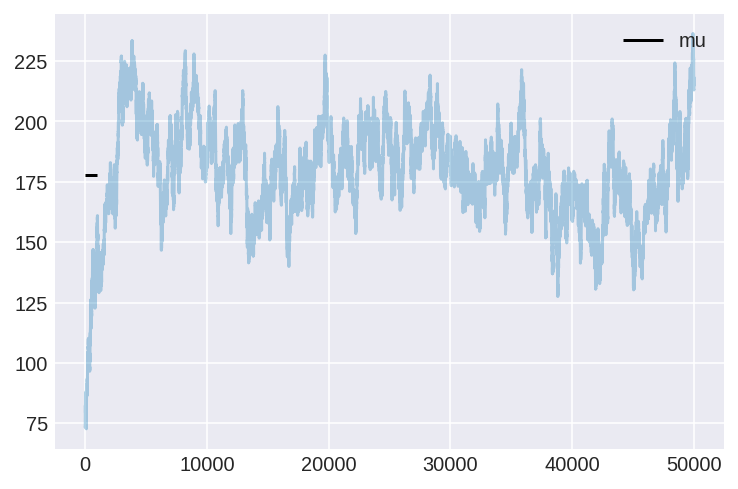

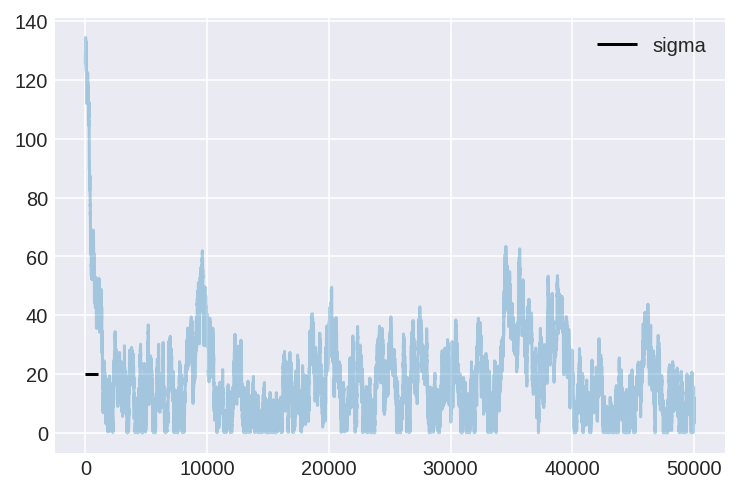

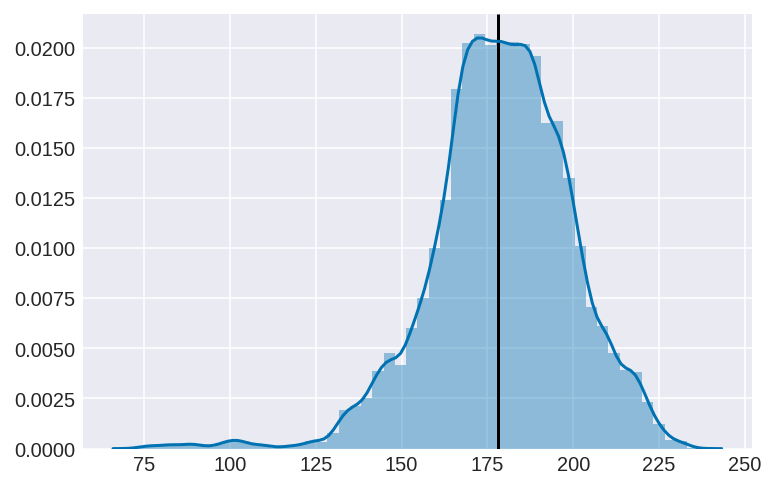

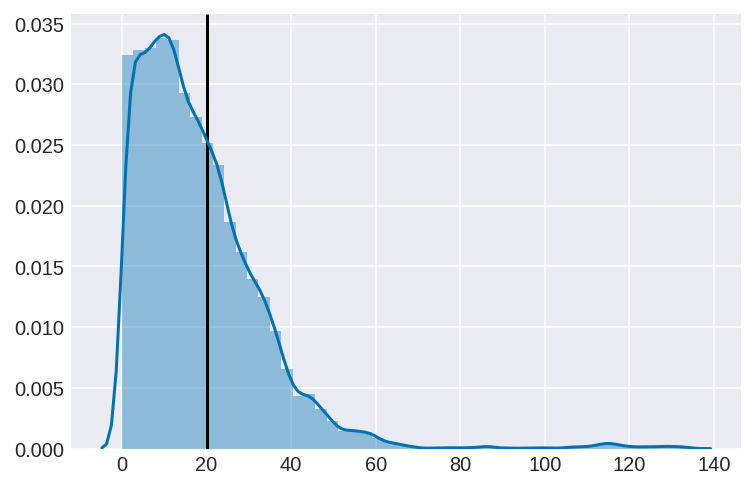

In [62]:
# Trace plots
plt.plot(sampled_mu, alpha=.3)
plt.hlines(true_mu, 0, 1000, zorder=4, label="mu")
plt.legend(loc='upper right')
plt.show()

plt.plot(sampled_sigma, alpha=.3)
plt.hlines(true_sigma, 0, 1000, zorder=4, label="sigma")
plt.legend(loc='upper right')
plt.show()

# Histogram of samples
sns.distplot(sampled_mu)
ymax = plt.ylim()[1]
plt.vlines(true_mu, 0, ymax)
plt.ylim(0, ymax)
plt.show()

sns.distplot(sampled_sigma)
ymax = plt.ylim()[1]
plt.vlines(true_sigma, 0, ymax)
plt.ylim(0, ymax)
plt.show()

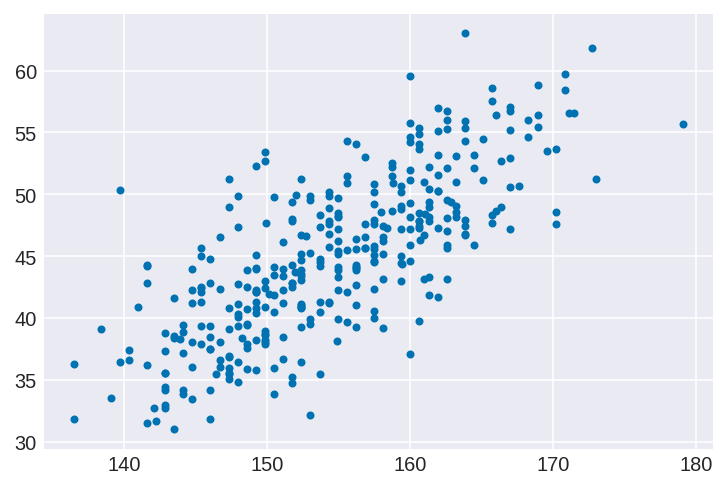

In [63]:
plt.plot(d2.height, d2.weight, '.');


In [83]:
w = d2.weight

0    47.825606
1    36.485807
2    31.864838
3    53.041915
4    41.276872
Name: weight, dtype: float64

### Build the model m4_3

In [0]:
# Observed data
n = len(d2)
true_mu = 178.
true_sigma = 20.
w = d2.weight

xs = np.random.uniform(1, 50, n)
ys = d2.height

# Prior
alpha = np.random.normal(loc=178., scale=100.)
beta = np.random.normal(loc=0., scale=10.)
rv_mu = alpha + beta * w
rv_sigma = np.random.uniform(low=0., high=50.)

# Calculate the likelihood
rv_likelihood = tfd.Normal(loc=true_mu, scale=true_sigma).log_prob

### Sampling the model

In [0]:
# Sampling likelihood
states = tfp.mcmc.sample_chain(
    num_results=50000,
    num_burnin_steps=500,
    current_state = tf.zeros(1),
    kernel=tfp.mcmc.HamiltonianMonteCarlo(
      target_log_prob_fn=rv_likelihood,
      step_size=0.5,
      num_leapfrog_steps=2),
    trace_fn=None)

### Trace the result

In [91]:
# Calculate sampled mu
sampled_mu = states

# Calculate sampled sigma
sampled_sigma = tf.sqrt(tf.math.squared_difference(sampled_mu, true_mu))

with tf.Session() as sess:
  sampled_mu = sess.run(sampled_mu)
mean_mu = np.mean(sampled_mu)
print("The estimated mu is:", mean_mu)

with tf.Session() as sess:
  sampled_sigma = sess.run(sampled_sigma)
mean_sigma = np.mean(sampled_sigma)
print("The estimated sigma is:", mean_sigma)

The estimated mu is: 168.90802
The estimated sigma is: 16.282608


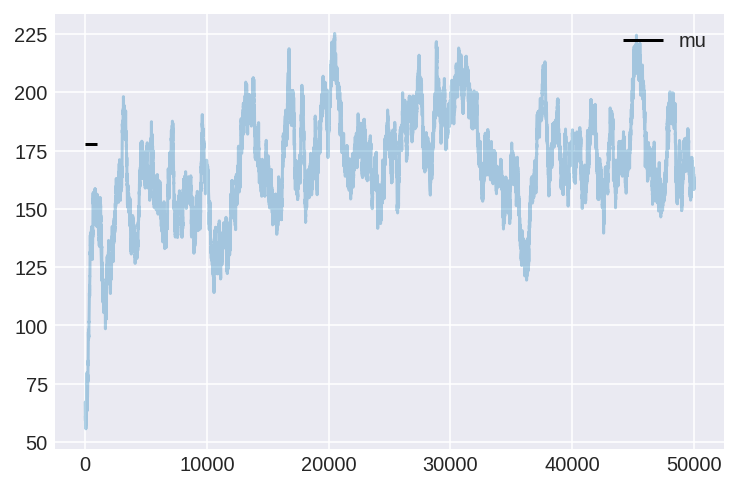

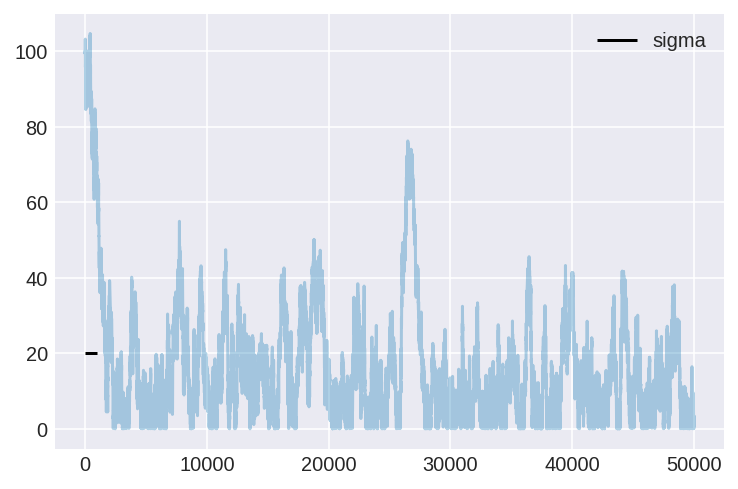

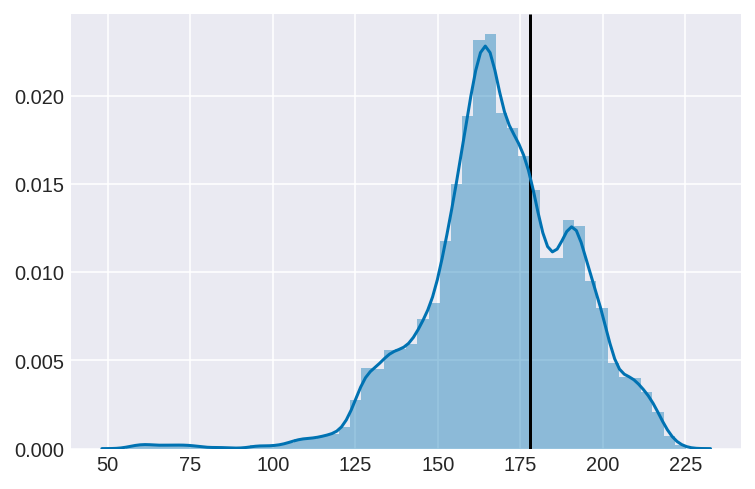

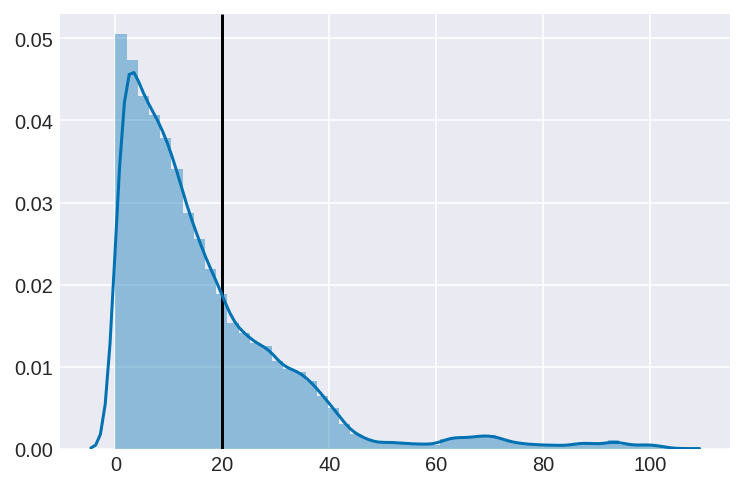

In [92]:
# Trace plots
plt.plot(sampled_mu, alpha=.3)
plt.hlines(true_mu, 0, 1000, zorder=4, label="mu")
plt.legend(loc='upper right')
plt.show()

plt.plot(sampled_sigma, alpha=.3)
plt.hlines(true_sigma, 0, 1000, zorder=4, label="sigma")
plt.legend(loc='upper right')
plt.show()

# Histogram of samples
sns.distplot(sampled_mu)
ymax = plt.ylim()[1]
plt.vlines(true_mu, 0, ymax)
plt.ylim(0, ymax)
plt.show()

sns.distplot(sampled_sigma)
ymax = plt.ylim()[1]
plt.vlines(true_sigma, 0, ymax)
plt.ylim(0, ymax)
plt.show()

Another alternative is to write mu inside the likelihood and not as a separate line.

height = pm.Normal('height', mu=alpha + beta * d2.weight, sd=sigma, observed=d2.height)

### Build the model m_N

In [0]:
# Observed data
n = len(d2)
true_mu = 178.
true_sigma = 20.
w = d2.weight
N = [10, 50, 150, 352][0]

xs = np.random.uniform(1, 50, n)
ys = d2.height

# Prior
alpha = np.random.normal(loc=178., scale=100.)
beta = np.random.normal(loc=0., scale=10.)
value = alpha + beta * w[:N]
value = tf.convert_to_tensor(value)
rv_mu = tfd.Deterministic(loc=value).log_prob(true_mu)
rv_sigma = np.random.uniform(low=0., high=50.)

# Calculate the likelihood
rv_likelihood = tfd.Normal(loc=true_mu, scale=true_sigma).log_prob

### Sampling the model

In [0]:
# Sampling likelihood
states = tfp.mcmc.sample_chain(
    num_results=50000,
    num_burnin_steps=500,
    current_state = tf.zeros(1),
    kernel=tfp.mcmc.HamiltonianMonteCarlo(
      target_log_prob_fn=rv_likelihood,
      step_size=0.5,
      num_leapfrog_steps=2),
    trace_fn=None)

### Trace the result

In [106]:
# Calculate sampled mu
sampled_mu = states

# Calculate sampled sigma
sampled_sigma = tf.sqrt(tf.math.squared_difference(sampled_mu, true_mu))

with tf.Session() as sess:
  sampled_mu = sess.run(sampled_mu)
mean_mu = np.mean(sampled_mu)
print("The estimated mu is:", mean_mu)

with tf.Session() as sess:
  sampled_sigma = sess.run(sampled_sigma)
mean_sigma = np.mean(sampled_sigma)
print("The estimated sigma is:", mean_sigma)

The estimated mu is: 174.22212
The estimated sigma is: 16.800152


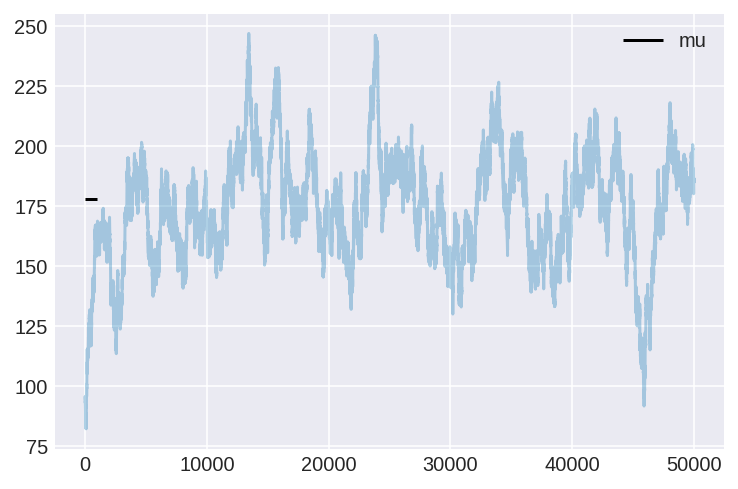

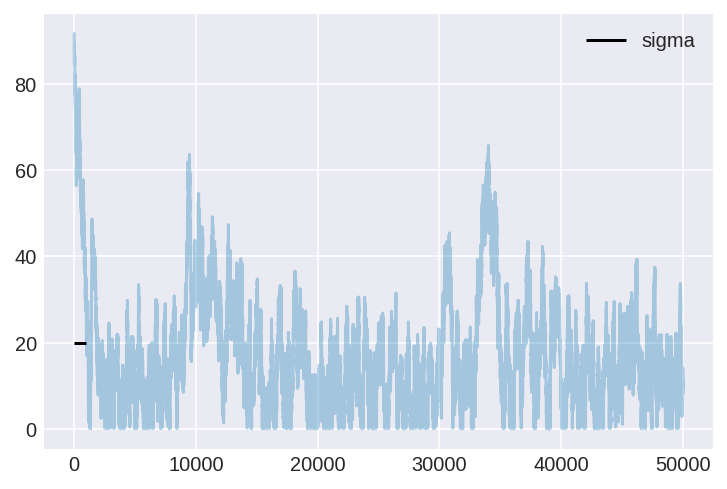

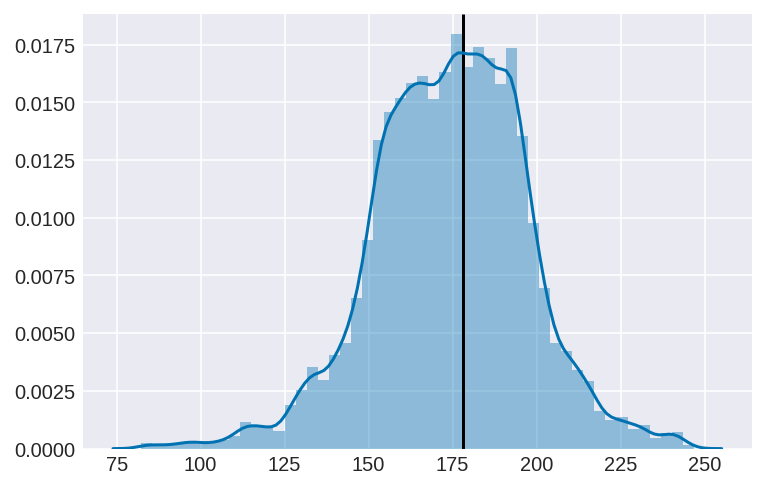

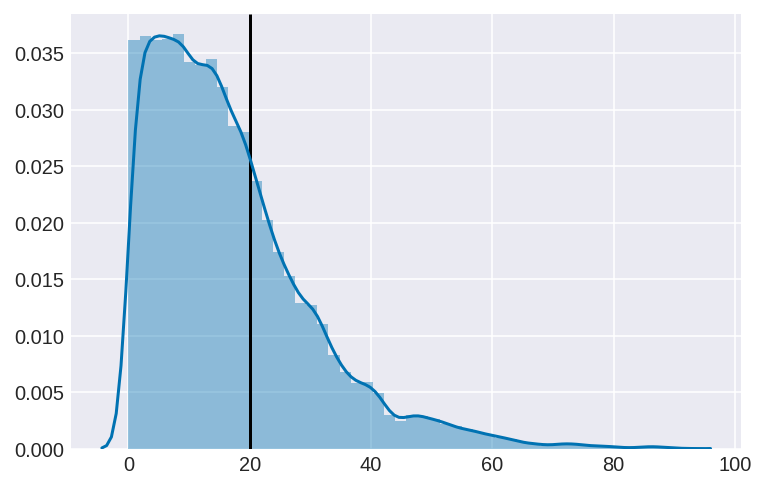

In [107]:
# Trace plots
plt.plot(sampled_mu, alpha=.3)
plt.hlines(true_mu, 0, 1000, zorder=4, label="mu")
plt.legend(loc='upper right')
plt.show()

plt.plot(sampled_sigma, alpha=.3)
plt.hlines(true_sigma, 0, 1000, zorder=4, label="sigma")
plt.legend(loc='upper right')
plt.show()

# Histogram of samples
sns.distplot(sampled_mu)
ymax = plt.ylim()[1]
plt.vlines(true_mu, 0, ymax)
plt.ylim(0, ymax)
plt.show()

sns.distplot(sampled_sigma)
ymax = plt.ylim()[1]
plt.vlines(true_sigma, 0, ymax)
plt.ylim(0, ymax)
plt.show()

## References

[1] Bayesian Statistics: Techniques and Models - Week1 ,2018.[Online].Available: https://www.coursera.org/learn/mcmc-bayesian-statistics/home/welcome
<br>
[2] D. Jason Koskinen,"Markov Chain Monte Carlo",Feb 2018.[Online].Available:http://www.nbi.dk/~koskinen/Teaching/AdvancedMethodsInAppliedStatistics2018/Lecture6_MCMC_Bayes.pdf
<br>
[3] Computational Statistics in Python,"Markov Chain Monte Carlo (MCMC)",[Online].Available: https://people.duke.edu/. 
<br>
[4] Tensorflow Statistical Distributions, [Online].Available: https://www.tensorflow.org/probability/api_docs/python/tfp/distributions. 
<br>
[5] TensorFlow Probability MCMC python package, [Online].Available: https://www.tensorflow.org/probability/api_docs/python/tfp/mcmc. 